In [1]:
import numpy as np
import pandas as pd

# from average_atom.core.average_atom_new import AverageAtom as AA
from average_atom.core.aa_types import AverageAtomFactory
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (5,3.5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Aluminum
name='Al'
Z, A = 13, 27 

ρ_solid = 2.699 #g/cc, the solid density of aluminum 
ρ = ρ_solid#8.1 # g/cc
ni_cc = ρ/(A*amu_to_AU*AU_to_g)
ni_AU = ni_cc*invcc_to_AU
rs = rs_from_n(ni_AU)
R  = 10*rs

Ti_eV = 1 
Te_eV = 1

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU


aa_empty = AverageAtomFactory.create_model("EmptyAtom", Z, A, Ti_AU, Te_AU, rs, R, 3, ignore_vxc=True)

________________________
Generating NPA
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
Intialized Potentials and Densities
Initialized


In [3]:
aa_empty.solve(verbose=True)

Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	μ = 4.255289479e-01, change: 0.000000000e+00 (converged=True)
	φe Err =       -inf, φe change =  1.433e-01
	ne Err =  1.878e-01, ne change =  3.846e-01
	Q =  0.000e+00 ->  6.776e+02, 
	Zstar guess =  3.000e+00. Current Zstar:  3.000e+00 (converged=True)
	Change =  4.548e-01
__________________________________________
TF Iteration 1
	μ = 4.255289479e-01, change: 0.000000000e+00 (converged=True)
	φe Err =       -inf, φe change =  7.967e-02
	ne Err =  8.941e-02, ne change =  3.027e-01
	Q =  6.776e+02 ->  9.858e+02, 
	Zstar guess =  3.000e+00. Current Zstar:  3.000e+00 (converged=True)
	Change =  3.612e-01
__________________________________________
TF Iteration 2
	μ = 4.255289479e-01, change: 0.000000000e+00 (converged=True)
	φe Err =        nan, φe change =  5.871e-02
	ne Err =  3.432e-02, ne change =  1.894e-01
	Q =  9.858e+02 ->  1.101e+03, 
	Zstar guess

/home/zach/plasma/average_atom/core/average_atom_new.py:559: RuntimeWarning: divide by zero encountered in divide
  rel_errs = (np.abs(A @ φe - b)[:-1]/b[:-1])
/home/zach/plasma/average_atom/core/average_atom_new.py:559: RuntimeWarning: invalid value encountered in divide
  rel_errs = (np.abs(A @ φe - b)[:-1]/b[:-1])


__________________________________________
TF Iteration 125
	μ = 4.255289479e-01, change: 0.000000000e+00 (converged=True)
	φe Err =       -inf, φe change =  3.405e-07
	ne Err =  2.142e-09, ne change =  1.546e-07
	Q =  1.290e+01 ->  1.290e+01, 
	Zstar guess =  3.000e+00. Current Zstar:  3.000e+00 (converged=True)
	Change =  4.618e-07
__________________________________________
TF Iteration 150
	μ = 4.255289479e-01, change: 0.000000000e+00 (converged=True)
	φe Err =       -inf, φe change =  2.137e-09
	ne Err =  1.374e-11, ne change =  9.700e-10
	Q =  1.290e+01 ->  1.290e+01, 
	Zstar guess =  3.000e+00. Current Zstar:  3.000e+00 (converged=True)
	Change =  2.904e-09
__________________________________________
TF Iteration 168
	μ = 4.255289479e-01, change: 0.000000000e+00 (converged=True)
	φe Err =       -inf, φe change =  6.812e-11
	ne Err =  4.408e-13, ne change =  3.092e-11
	Q =  1.290e+01 ->  1.290e+01, 
	Zstar guess =  3.000e+00. Current Zstar:  3.000e+00 (converged=True)
	Change =  9.

(<Figure size 4000x1600 with 2 Axes>,
 array([<Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$\\phi$ [A.U.]'>,
        <Axes: xlabel='$|r-R_1|$ [A.U.]', ylabel='$n$ [A.U.]'>],
       dtype=object))

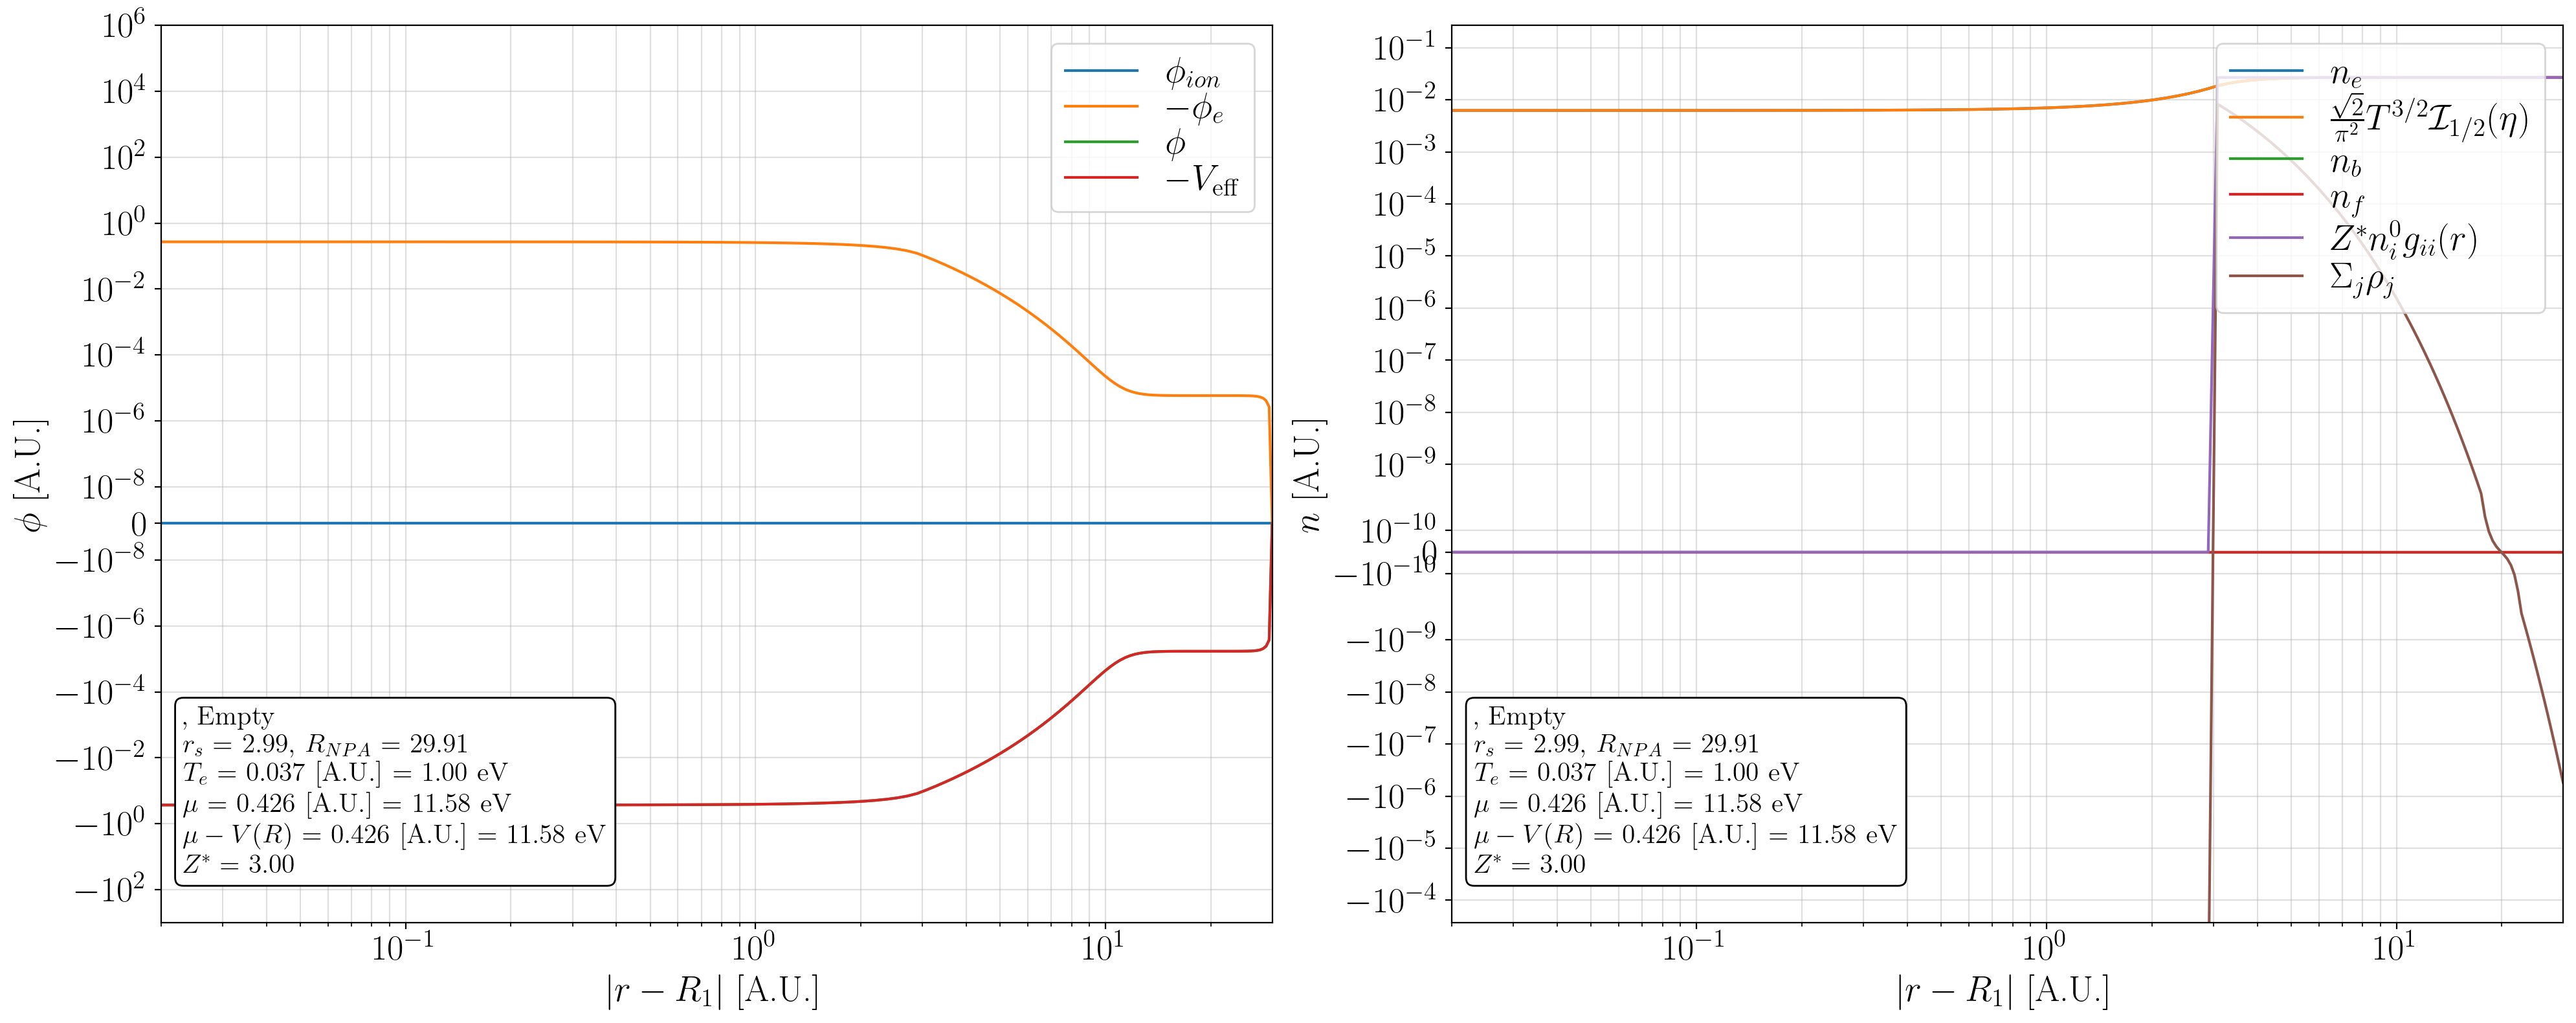

In [4]:
aa_empty.make_plots()

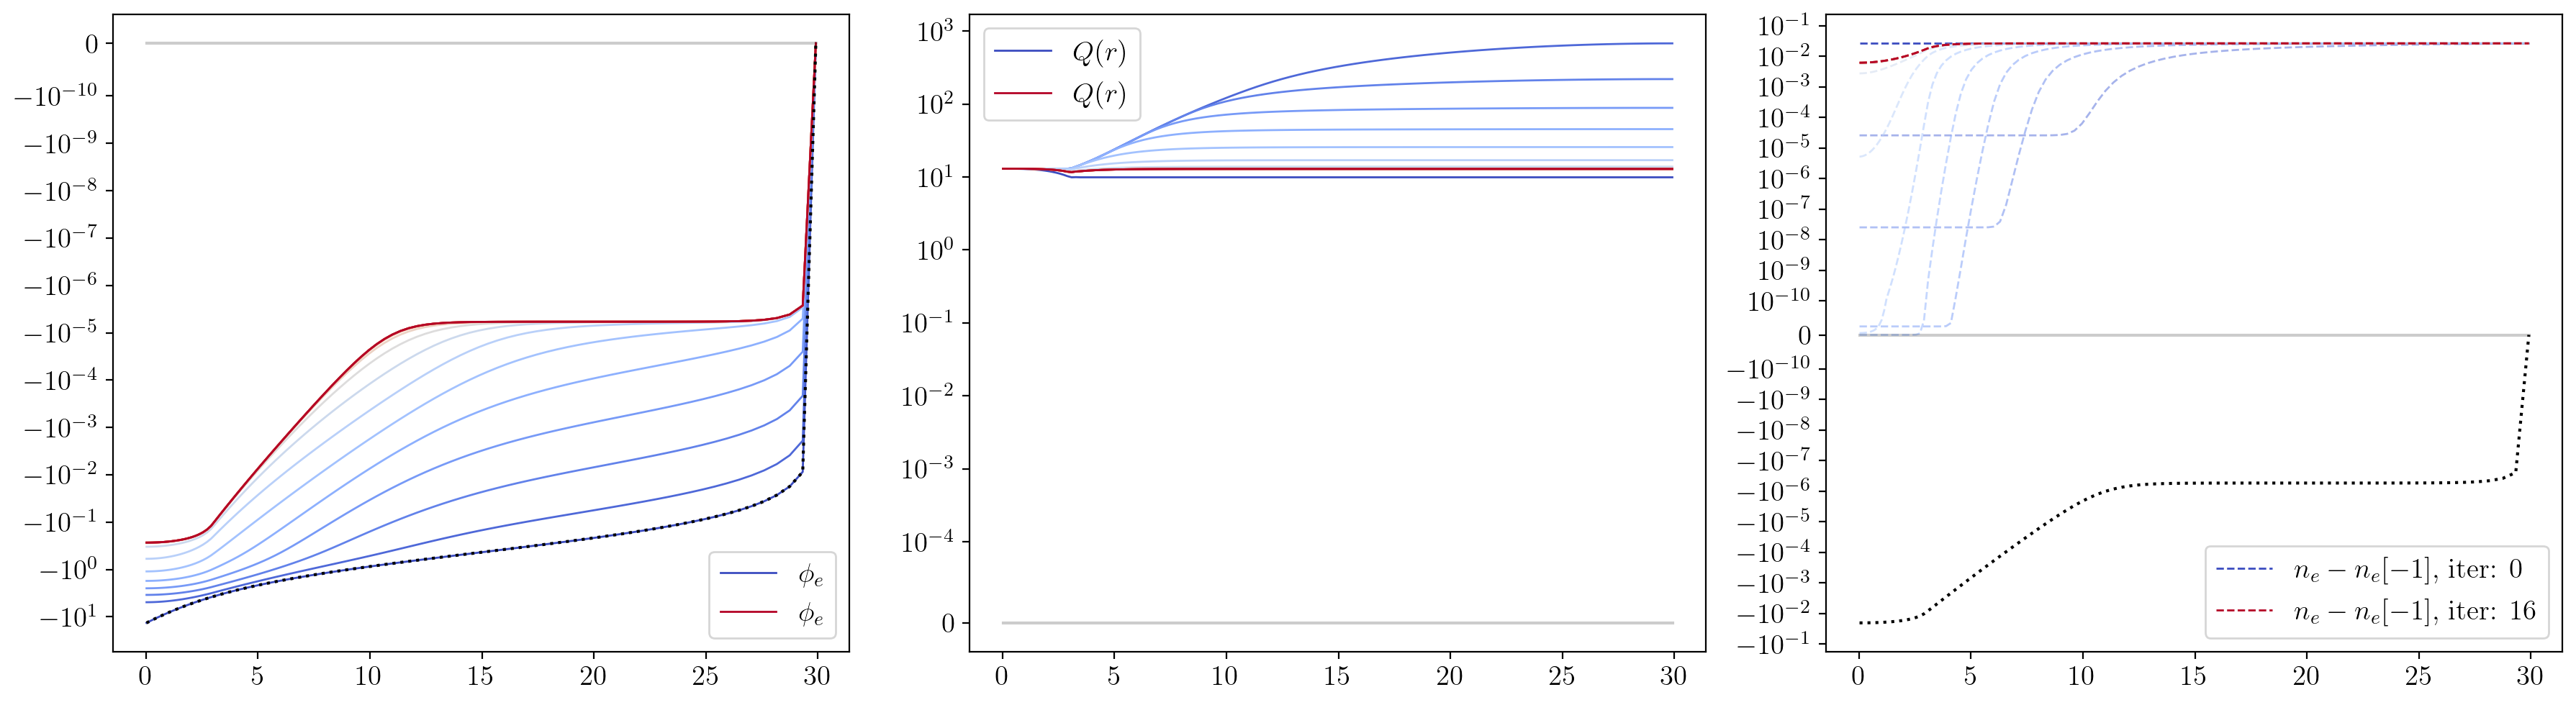

In [5]:
def plot_convergence(aa, axs=None):
    if axs is None:
        fig, axs = plt.subplots(ncols=3,figsize=(18,5),facecolor='w', dpi=200)
    
    # ELectric potential
    slice_by_num = 10
    ax = axs[0]
    colors = plt.cm.coolwarm(np.linspace(0, 1,len(aa.φe_list[::slice_by_num])))
    for i, (φe, ne, μ, ne_bar) in enumerate(zip(aa.φe_list[::slice_by_num], aa.ne_list[::slice_by_num], aa.μ_list[::slice_by_num],aa.ne_bar_list[::slice_by_num])):
        if i ==0 or i==len(aa.φe_list[::slice_by_num])-1:
            ax.plot(aa.grid.xs, (φe+aa.φion),linewidth=1,color=colors[i],alpha=1, label=r'$\phi_e$'.format(i))
            # ax.plot(aa.grid.xs, -aa.grid.dfdx(φe+aa.φion),linewidth=1,color=colors[i],alpha=1, label=r'$\vec E$'.format(i))
            # ax.plot(aa.grid.xs, aa.get_βVeff(φe, ne, ne_bar),linewidth=1,color=colors[i],alpha=1, label=r'$\beta V_{{\rm eff}}$'.format(i))
        else:
            ax.plot(aa.grid.xs, φe+aa.φion,linewidth=1,color=colors[i],alpha=1)
            # ax.plot(aa.grid.xs, -aa.grid.dfdx(φe+aa.φion),linewidth=1,color=colors[i],alpha=1)
            # ax.plot(aa.grid.xs, aa.get_βVeff(φe, ne, ne_bar),linewidth=1,color=colors[i],alpha=1)
    # ax.plot(aa.grid.xs, aa.get_φe( (aa.ρi - aa.ne) )[0] + aa.φion  ,'k:', label=r'$\phi$ check') 
    ax.set_yscale('symlog',linthresh=1e-10)
    ax.plot(aa.grid.xs, aa.φe_init + aa.φion, 'k:')

    # number density
    ax = axs[1]
    for i, (ne, ρi) in enumerate(zip(aa.ne_list[::slice_by_num], aa.ρi_list[::slice_by_num])):
        if i ==0 or i==len(aa.ne_list[::slice_by_num])-1:
            if i==0: 
                ne_bar_0 = ne[-1]
            ax.plot(aa.grid.xs, [aa.grid.integrate_f(-ne + ρi, end_index = index) + aa.Z for index in range(len(aa.grid.xs))],linewidth=1,color=colors[i],alpha=1, label=r'$Q(r)$'.format(i*slice_by_num))
            # ax.plot(aa.grid.xs, -ne + 0*ρi + ne[-1],linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # ax.plot(aa.grid.xs, -ne + ρi,linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # ax.plot(aa.grid.xs, -ne + ne_bar_0,linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # ax.plot(aa.grid.xs, -ρi[-1] + ρi,linewidth=1,color=colors[i],alpha=1, label=r'$\rho$'.format(i))
            # pass
        else:
            ax.plot(aa.grid.xs, [aa.grid.integrate_f(-ne + ρi, end_index = index) + aa.Z for index in range(len(aa.grid.xs))],linewidth=1,color=colors[i],alpha=1)
            # print(ne[-1]-ne_bar_0)
            # ax.plot(aa.grid.xs, -ne + ρi ,linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            # ax.plot(aa.grid.xs, -ne + ne_bar_0 ,linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            # ax.plot(aa.grid.xs, -ρi[-1]+ ρi ,linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            pass
    # for i in range(int(aa.R/aa.rs)):
    #     ax.axvline(aa.rs*i, color='k', linestyle='--', alpha=0.2)
    # ax.set_xscale('log')
    # ax.plot(aa.grid.xs, (aa.gii)-1, 'k:')
    ax.set_yscale('symlog',linthresh=1e-4)

            
    # number density
    ax = axs[2]
    for i, (φe, ne, μ, ne_bar) in enumerate(zip(aa.φe_list[::slice_by_num], aa.ne_list[::slice_by_num], aa.μ_list[::slice_by_num],aa.ne_bar_list[::slice_by_num])):
        ne_TF = aa.get_ne_TF(φe, ne, μ, ne_bar)
        if i ==0 or i==len(aa.ne_list[::slice_by_num])-1:
            # ax.plot(aa.grid.xs, ne - ne_TF,linewidth=1,color=colors[i],alpha=1, label=r'$n_e/n_e^{{TF}}-1$, iter: {0}'.format(i))
            # ax.plot(aa.grid.xs, ne_TF-ne_TF[-1],linewidth=1,color=colors[i],alpha=1, label=r'$n_e^{{TF}} - n_e^{{TF}}[-1]$, iter: {0}'.format(i*slice_by_num))
            ax.plot(aa.grid.xs, ne-0*ne[-1],linewidth=1,color=colors[i],linestyle='--',alpha=1, label=r'$n_e - n_e[-1]$, iter: {0}'.format(i))
            # pass
        else:
            # ax.plot(aa.grid.xs, ne - ne_TF, linewidth=1,linestyle='-',color=colors[i],alpha=0.5)
            # ax.plot(aa.grid.xs, ne_TF-ne_TF[-1],linewidth=1,color=colors[i],alpha=1)
            ax.plot(aa.grid.xs, ne-0*ne[-1], linewidth=1,linestyle='--',color=colors[i],alpha=0.5)
            

            # print(np.abs(ne/ne_TF-1))
            # print(np.where( np.abs(ne/ne_TF-1)>1e-6 ))
            # print(aa.grid.xs[np.where( np.abs(ne/ne_TF-1) > 1e-8)][0]/10, 1/(np.sum(aa.grid.xs*np.abs(ne/ne_TF-1))/np.sum(np.abs(ne/ne_TF-1))))
    # ax.set_ylim()
    # ax.plot(aa.grid.xs, npa.get_ne_TF(npa.φe, npa.ne, npa.μ, npa.ne_bar) - npa.get_ne_TF(npa.φe, npa.ne, npa.μ, npa.ne_bar)[-1] , 'k:')
    ax.plot(aa.grid.xs, aa.get_ne_TF(aa.φe, aa.ne_bar*np.ones_like(aa.ne), aa.μ, aa.ne_bar) - aa.get_ne_TF(aa.φe, aa.ne_bar*np.ones_like(aa.ne), aa.μ, aa.ne_bar)[-1] , 'k:')
    ax.set_yscale('symlog',linthresh=1e-10)
    # ax.set_xscale('log')
    for ax in axs:
        ax.legend(fontsize=14)
        ax.tick_params(labelsize=14)
        ax.plot(aa.grid.xs, np.zeros_like(aa.ne),'k', alpha=0.2)
    plt.tight_layout()
    
# plot_convergence(aa)
plot_convergence(aa_empty)